# **Project Phase 2: Model Execution Instructions**

This directory contains the source code for the 6 machine learning and statistical models applied to the NYC Green Taxi dataset for the EAS 587 course project.

## **Requirements**

* A web browser  
* A Google Account (for using Google Colab)

## **Files Included**

* `taxi_data.csv`: The dataset used by all notebooks.  
* `model_1_LinearRegression.ipynb`: Notebook for the Linear Regression model.  
* `model_2_KNN.ipynb`: Notebook for K-Nearest Neighbors and K-Means models.  
* `model_3_DecisionTree.ipynb`: Notebook for the Decision Tree classification model.  
* `model_4_RandomForest.ipynb`: Notebook for the Random Forest regression model.  
* `model_5_DBSCAN.ipynb`: Notebook for the DBSCAN clustering model.  
* `model_6_ARIMA.ipynb`: Notebook for the ARIMA and Prophet time-series models.

## **Step-by-Step Execution Instructions**

To reproduce the results, please follow these steps for each of the 6 notebooks.

1. **Navigate to Google Colab** Open your web browser and go to [https://colab.research.google.com/](https://colab.research.google.com/).  
2. **Upload Project Files** On the left-hand side of the Colab interface, click the **"Files"** icon (it looks like a folder). Click the **"Upload to session storage"** icon and select all the files from this `src/` directory (the 6 `.ipynb` notebooks and `taxi_data.csv`). Wait for all files to finish uploading.  
3. **Open a Notebook** In the file browser on the left, double-click on one of the notebook files (e.g., `LinearRegression.ipynb`) to open it in the main editor.  
4. **Run the Notebook** Once the notebook is open and has connected to a runtime, go to the top menu and select **Runtime \-\> Run all**.  
5. **View Results** The notebook will now execute from the first cell to the last, producing all the model metrics, tables, and visualizations described in the report.  
6. **Repeat for Other Models** Repeat steps 3-5 for the remaining 5 notebook files to see the results for each model. Make sure you upload the `taxi_data.csv` file for every python notebook.

**Important Note on Colab Runtimes:** The files uploaded to a Google Colab session are temporary. If your session disconnects or times out (e.g., after being idle), the uploaded files will be deleted. If this happens, you will need to re-upload the `taxi_data.csv` file (Step 2).



In [ ]:
import pandas as pd

# Load dataset again
df = pd.read_csv('taxi_data.csv', low_memory=False, dtype={'store_and_fwd_flag': 'str'})

# Now continue with the feature engineering code
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], errors='coerce')

df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['lpep_pickup_datetime'].dt.dayofweek
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60


In [6]:
# Drop rows with missing or invalid durations or distances
df = df[(df['trip_duration'] > 0) & (df['trip_distance'] > 0)]

# Remove extreme outliers (e.g., distance > 50 miles or duration > 120 minutes)
df = df[(df['trip_distance'] <= 50) & (df['trip_duration'] <= 120)]


In [7]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')
categorical_cols = ['RatecodeID', 'payment_type', 'store_and_fwd_flag']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Features and target
X = df[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
        'improvement_surcharge', 'congestion_surcharge', 'trip_duration',
        'pickup_hour', 'pickup_dayofweek'] +
       [col for col in df.columns if col.startswith(('RatecodeID_', 'payment_type_', 'store_and_fwd_flag_'))]]

y = df['trip_distance']
# Drop rows with any NaN values in selected features or target
df = df.dropna(subset=[
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'trip_duration',
    'pickup_hour', 'pickup_dayofweek'
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


MAE: 0.61
RMSE: 1.27
R²: 0.820


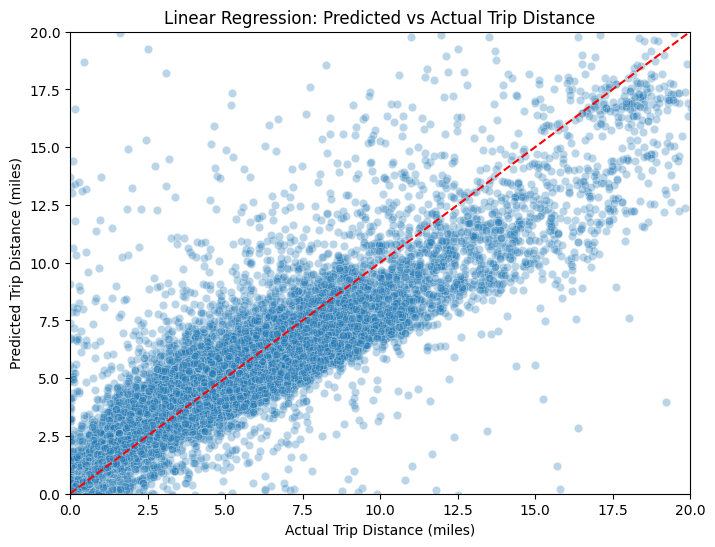

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')  # perfect prediction line
plt.xlabel('Actual Trip Distance (miles)')
plt.ylabel('Predicted Trip Distance (miles)')
plt.title('Linear Regression: Predicted vs Actual Trip Distance')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()


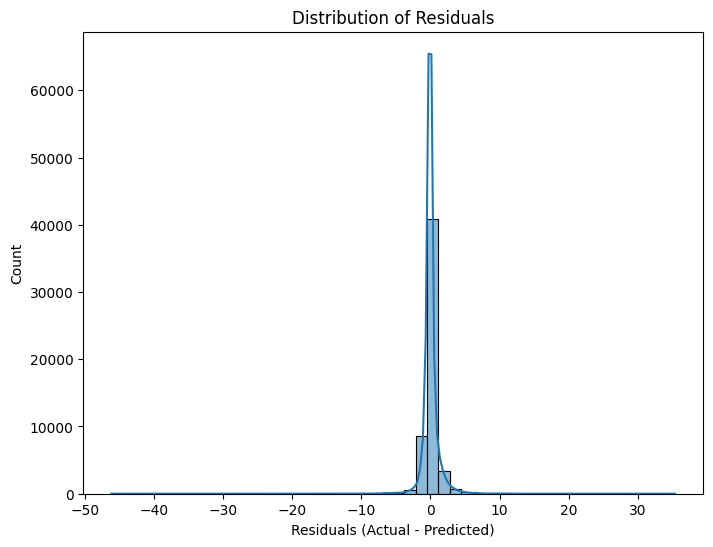

In [12]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Distribution of Residuals')
plt.show()


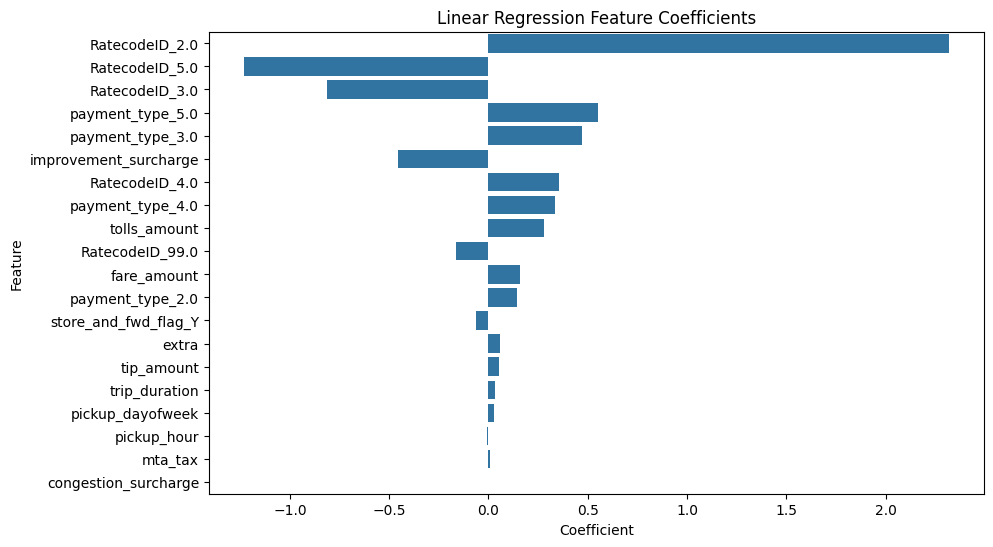

In [13]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Linear Regression Feature Coefficients')
plt.show()


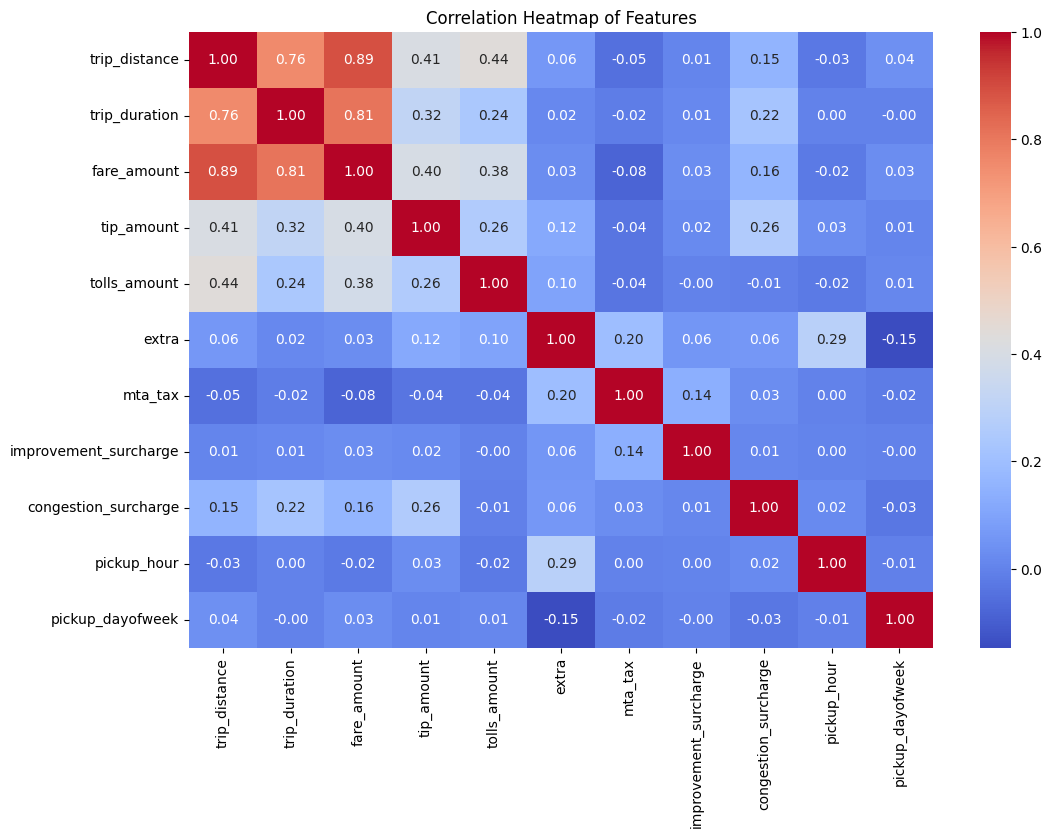

In [14]:
plt.figure(figsize=(12, 8))
numeric_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tip_amount',
                'tolls_amount', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge',
                'pickup_hour', 'pickup_dayofweek']

corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()


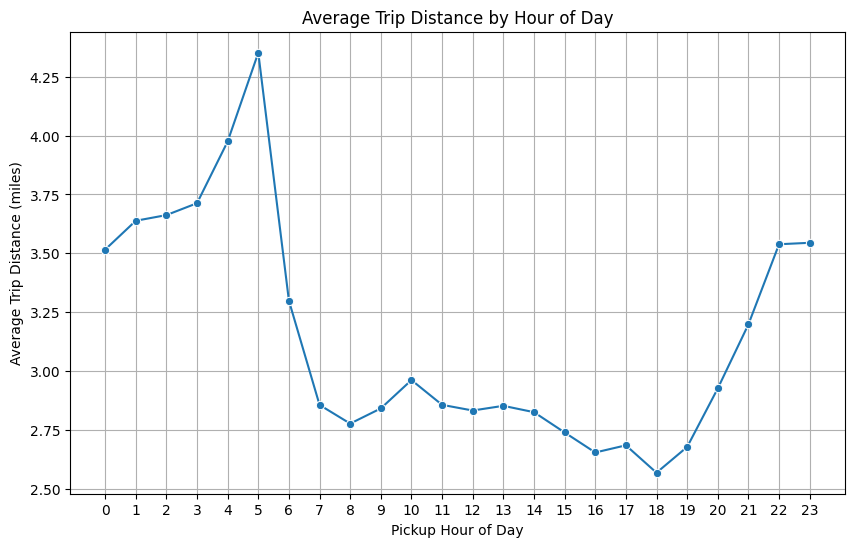

In [15]:
hourly_distance = df.groupby('pickup_hour')['trip_distance'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='trip_distance', data=hourly_distance, marker='o')
plt.xticks(range(0, 24))
plt.xlabel('Pickup Hour of Day')
plt.ylabel('Average Trip Distance (miles)')
plt.title('Average Trip Distance by Hour of Day')
plt.grid(True)
plt.show()
